In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances

import umap
import hdbscan

In [8]:
RANDOM_STATE = 42
UMAP_CLUSTER_DIM = 50
UMAP_VIZ_DIM = 2
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST = 0.0
HDBSCAN_MIN_CLUSTER_SIZE = 20
DESIRED_K = 3

In [9]:
df = pd.read_csv('../datasets/final_dataset.csv')
try:
    df
except NameError:
    raise RuntimeError("DataFrame `df` not found. Load your cleaned dataset into variable `df` before running.")


slug_col = "slug_clean" if "slug_clean" in df.columns else ("slug" if "slug" in df.columns else None)

In [10]:
def detect_embeddings_from_df(df):

    mpnet_cols = sorted([c for c in df.columns if c.startswith("mpnet_")], key=lambda s: int(s.split("_")[1]) if "_" in s and s.split("_")[-1].isdigit() else s)
    if mpnet_cols:
        emb = df[mpnet_cols].to_numpy(dtype=float)
        return emb


    for col in ("embedding", "embeddings", "embed"):
        if col in df.columns:
            sample = df[col].dropna().iloc[0]
            if isinstance(sample, (list, np.ndarray)):
                emb = np.vstack(df[col].apply(lambda x: np.asarray(x, dtype=float)))
                return emb

    return None

embeddings = detect_embeddings_from_df(df)

In [11]:
if embeddings is None:
    if 'embeddings' in globals() and isinstance(globals()['embeddings'], np.ndarray):
        embeddings = globals()['embeddings']
    else:
        raise RuntimeError(
            "Could not detect embeddings. Either provide columns 'mpnet_0'.. or a column 'embedding' with list/array per row, "
            "or have a numpy array named `embeddings` in scope."
        )

print("Detected embeddings shape:", embeddings.shape)

Detected embeddings shape: (3758, 768)


In [14]:
feature_parts = [embeddings]

tag_columns = [c for c in df.columns if c.startswith("tag_")]
print(f"Found {len(tag_columns)} tag columns.")
if tag_columns:
    tags_arr = df[tag_columns].fillna(0).astype(float).values
    feature_parts.append(tags_arr)

if "acRate" in df.columns:
    ac = df["acRate"].astype(float).fillna(df["acRate"].mean()).values.reshape(-1, 1)
    feature_parts.append(ac)
    print("Included acRate as feature.")
else:
    print("No 'acRate' column found; continuing without it.")

X_raw = np.hstack(feature_parts)
print("Feature matrix shape:", X_raw.shape)

Found 72 tag columns.
Included acRate as feature.
Feature matrix shape: (3758, 841)


In [15]:
print("Running UMAP (cluster dim -> {} ) ...".format(UMAP_CLUSTER_DIM))
umap_cluster = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    n_components=UMAP_CLUSTER_DIM,
    metric='cosine',
    random_state=RANDOM_STATE,
    min_dist=UMAP_MIN_DIST
)
X_umap_50 = umap_cluster.fit_transform(X_raw)
print("UMAP-50 result:", X_umap_50.shape)

print("Running UMAP (2D) for visualization ...")
umap_viz = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    n_components=UMAP_VIZ_DIM,
    metric='cosine',
    random_state=RANDOM_STATE,
    min_dist=UMAP_MIN_DIST
)
X_umap_2 = umap_viz.fit_transform(X_raw)
print("UMAP-2 result:", X_umap_2.shape)

Running UMAP (cluster dim -> 50 ) ...


/Users/adityasharma/miniconda3/envs/assessment-clustering/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP-50 result: (3758, 50)
Running UMAP (2D) for visualization ...


/Users/adityasharma/miniconda3/envs/assessment-clustering/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP-2 result: (3758, 2)


In [16]:
print("Running HDBSCAN (min_cluster_size={}) ...".format(HDBSCAN_MIN_CLUSTER_SIZE))
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    metric='euclidean',
    cluster_selection_method='eom'
)
hdb_labels = clusterer.fit_predict(X_umap_50)  # -1 means noise
df['hdb_label'] = hdb_labels
n_hdb_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
print("HDBSCAN found clusters (excluding noise):", n_hdb_clusters)
print(pd.Series(hdb_labels).value_counts().sort_index())

Running HDBSCAN (min_cluster_size=20) ...
HDBSCAN found clusters (excluding noise): 52
-1     923
 0     313
 1      94
 2      62
 3      59
 4      51
 5      54
 6      28
 7      73
 8      31
 9      66
 10     27
 11     67
 12     49
 13     33
 14    111
 15     22
 16     54
 17     43
 18     37
 19     25
 20     35
 21     45
 22     53
 23     42
 24     38
 25     24
 26     25
 27    134
 28     25
 29     63
 30     23
 31     42
 32     51
 33     50
 34     33
 35     57
 36     64
 37     34
 38     21
 39     35
 40     45
 41     45
 42     35
 43     51
 44     77
 45     70
 46     28
 47     98
 48     41
 49     66
 50     36
 51     50
Name: count, dtype: int64


/Users/adityasharma/miniconda3/envs/assessment-clustering/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/adityasharma/miniconda3/envs/assessment-clustering/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
if n_hdb_clusters >= DESIRED_K:
    print("Merging HDBSCAN clusters into exactly", DESIRED_K, "via centroid merging...")
    valid_clusters = sorted([lab for lab in np.unique(hdb_labels) if lab != -1])
    centroids = []
    centroid_orig = []
    for cl in valid_clusters:
        pts = X_umap_50[hdb_labels == cl]
        centroids.append(pts.mean(axis=0))
        centroid_orig.append(cl)
    centroids = np.vstack(centroids)

    # cluster centroids into K groups
    ag = AgglomerativeClustering(n_clusters=DESIRED_K, linkage='ward')
    merged_centroid_labels = ag.fit_predict(centroids)
    hdb_to_merged = {orig: int(merged_centroid_labels[i]) for i, orig in enumerate(centroid_orig)}

    merged_labels = np.full_like(hdb_labels, fill_value=-1)
    for i, lab in enumerate(hdb_labels):
        if lab == -1:
            merged_labels[i] = -1
        else:
            merged_labels[i] = hdb_to_merged[lab]

    # assign noise to nearest merged centroid so every point has a label 0..K-1
    noise_idx = np.where(merged_labels == -1)[0]
    if noise_idx.size > 0:
        print(f"Assigning {noise_idx.size} noise points to nearest merged centroid...")
        merged_centroid_coords = np.zeros((DESIRED_K, X_umap_50.shape[1]))
        for m in range(DESIRED_K):
            origs = [orig for orig, lbl in hdb_to_merged.items() if lbl == m]
            group_pts = np.vstack([X_umap_50[hdb_labels == orig] for orig in origs])
            merged_centroid_coords[m] = group_pts.mean(axis=0)
        dists = pairwise_distances(X_umap_50[noise_idx], merged_centroid_coords, metric='euclidean')
        nearest = np.argmin(dists, axis=1)
        merged_labels[noise_idx] = nearest

    final_labels = merged_labels
    method_used = "HDBSCAN->merge_centroids->K"
else:
    print(f"HDBSCAN found < {DESIRED_K} clusters; falling back to KMeans(n_clusters={DESIRED_K}) on UMAP-50")
    km = KMeans(n_clusters=DESIRED_K, random_state=RANDOM_STATE, n_init=20)
    final_labels = km.fit_predict(X_umap_50)
    method_used = "KMeans_on_UMAP50"

df['cluster_3'] = final_labels.astype(int)
print("Final 3-cluster counts:")
print(pd.Series(final_labels).value_counts().sort_index())

Merging HDBSCAN clusters into exactly 3 via centroid merging...
Assigning 923 noise points to nearest merged centroid...
Final 3-cluster counts:
0    3018
1     313
2     427
Name: count, dtype: int64


/Users/adityasharma/miniconda3/envs/assessment-clustering/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adityasharma/miniconda3/envs/assessment-clustering/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adityasharma/miniconda3/envs/assessment-clustering/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


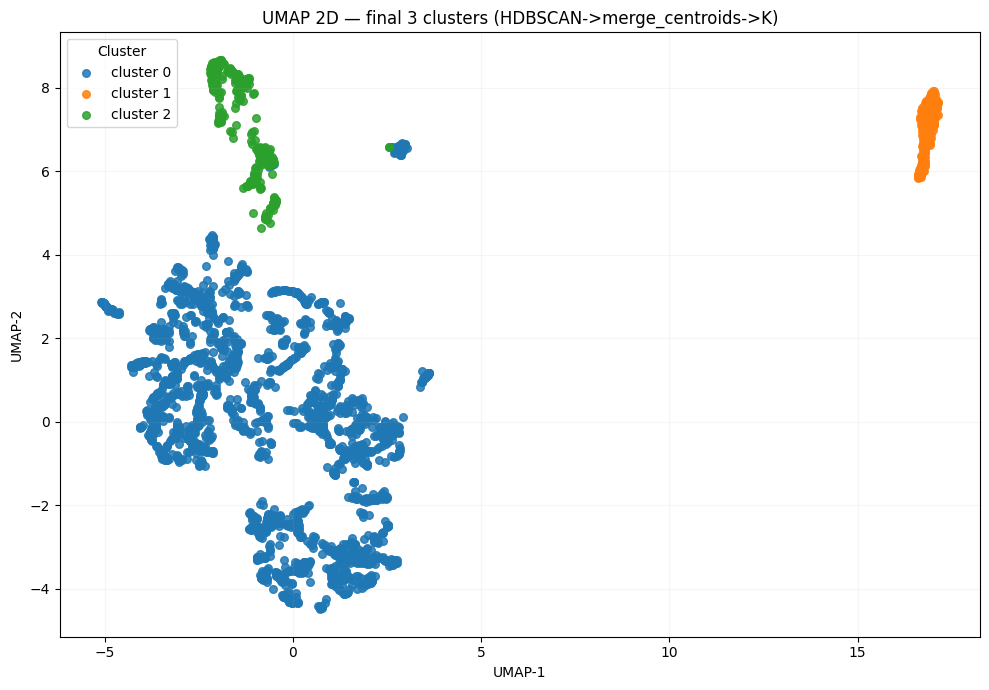

In [18]:
plt.figure(figsize=(10, 7))
unique_labels = sorted(np.unique(final_labels))
cmap = plt.cm.tab10

for i, lab in enumerate(unique_labels):
    idx = final_labels == lab
    lbl_name = f"cluster {int(lab)}"
    plt.scatter(X_umap_2[idx, 0], X_umap_2[idx, 1], s=30, alpha=0.85, label=lbl_name, marker='o')

plt.title(f"UMAP 2D — final 3 clusters ({method_used})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster", loc="best")
plt.grid(alpha=0.12)
plt.tight_layout()
plt.show()